# 3D analysis of X-ray Chandra data using gammapy

This notebook explores the possibility of performing a 3D (X,Y,E) analysis of X-ray data using the gammapy gamma-ray analysis tool.  
While at gamma-ray energies (due to moderate PSF), most sources can be represented by simple analitical functions (points, Gaussian, disks) this is less common in X-rays due to arcsec PSFs.  

Here we test the 3D analysis on a geometrically simple target (composite SNR IGR J14003-6326 aka SNR G310.6-1.6).  
In X-rays a nearly circular SNR shell, a PWN, and a pulsar are detected that we will model jointly.

The source is also sufficiently small (arcmin scale) to consider a flat exposure map and not having to handle CCD gaps.

Refs:
- [Discovery of a Highly Energetic Pulsar Associated with IGR J14003-6326 in the Young Uncataloged Galactic Supernova Remnant G310.6-1.6](https://ui.adsabs.harvard.edu/abs/2010ApJ...716..663R/abstract)
-[On the Expansion, Age, and Origin of the Puzzling Shell/Pulsar-wind Nebula G310.6-1.6](https://ui.adsabs.harvard.edu/abs/2019ApJ...887..233R/abstract)

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import astropy.units as u


import gammapy
gammapy.__version__

'0.19'

In [10]:

from gammapy.irf import EDispKernel,EDispKernelMap, EffectiveAreaTable2D
from gammapy.maps import WcsGeom, MapAxis, WcsNDMap, Map

from gammapy.modeling.models import PowerLawSpectralModel, GaussianSpectralModel
from gammapy.modeling.models.spatial import TemplateSpatialModel, GaussianSpatialModel, ShellSpatialModel
from gammapy.modeling.models import SkyModel
from gammapy.modeling import Fit
from gammapy.modeling.models import SpectralModel, Parameter

from gammapy.datasets.io import OGIPDatasetReader
from gammapy.datasets import MapDataset



In [11]:
# Implementing a quick absorption to avoid loading XSpec models for this example.
# Loading sherpa Xspec models is possible and currently being tested in gammapy

class WAbsSpectralModel(SpectralModel):
    tag = "WAbsSpectralModel"
    NH = Parameter("NH", "2.1e18 cm-2", min=0)
   
    @staticmethod
    def cross_section(energy):
        edges =  [0.030,  0.100, 0.284, 0.400, 0.532, 0.707, 0.867, 1.303, 1.840, 2.471, 3.210, 4.038, 7.111, 8.331, 10, 11]*u.keV   # 1 more edge
        axis = MapAxis.from_edges(edges, name="energy_true", interp="lin")
 
        c0 = np.array([17.3, 34.6, 78.1, 71.4, 95.5, 308.9, 120.6, 141.3, 202.7, 342.7, 352.2, 433.9, 629.0, 701.2])
        c1=np.array([608.1, 267.9, 18.8, 66.8, 145.8, -380.6, 169.3, 146.8, 104.7, 18.7, 18.7, -2.4, 30.9, 25.2])
        c2=np.array([-2150., -476.1, 4.3, -51.4, -61.1, 294.0, -47.7, -31.5, -17.0, 0.0, 0,0, 0.75, 0.0, 0.0])
  
        indices = axis.coord_to_idx(energy)
        indices = np.clip(indices, 0, 13)
        
        e_no_unit = energy.to_value("keV")
        cross_section = (c0[indices] + c1[indices]*e_no_unit  + c2[indices]*e_no_unit**2)
        cross_section *= e_no_unit**-3
        cross_section = cross_section*1e-24*u.cm**2
     
        return cross_section

    @staticmethod
    def evaluate(energy, NH):
        sigma = WAbsSpectralModel.cross_section(energy) 
        return np.exp(-sigma*NH)

In [12]:
arffile='data/SNR-circle.arf'
rmffile='data/SNR-circle-ERrebin16-ET10eV.rmf'
cubefile="data/Cube_IGRJ1400_46pix_XYrebin8_Erebin16.fits"


In [13]:
E1, E2= 0.7, 7

cube_data=Map.read(cubefile,map_type='wcs')
cube_data.data = np.array(cube_data.data,dtype='float64')

#i1,i2 =cube_data.geom.axes[0].coord_to_idx([E1,E2])
#cube_data = cube_data.slice_by_idx({"energy": slice(i1,i2)})
livetime=cube_data.meta['EXPOSURE']*u.s
print(livetime)



142434.565239242 s


In [14]:
cube_data.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

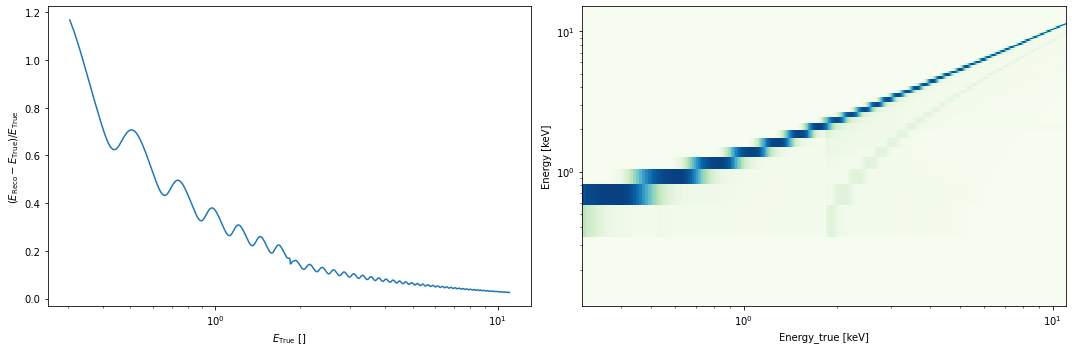

In [15]:
# Strange effects on the rebinned RMF produced by mkacisrmf
# Should maybe interpolate in gammapy
# Issue mentionned in BUG section of mkacisrmf
# https://cxc.harvard.edu/ciao/ahelp/mkacisrmf.html

rmf=EDispKernel.read(rmffile)
rmf.peek()
#edisp=EDispKernelMap.from_edisp_kernel(rmf, geom=cube_data.geom.to_image())
edisp=EDispKernelMap.from_edisp_kernel(rmf, geom=None)




In [16]:
print(edisp.edisp_map)
print(cube_data)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy', 'energy_true']
	shape : (2, 1, 64, 1070)
	ndim  : 4
	unit  : 
	dtype : float32

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (46, 46, 64)
	ndim  : 3
	unit  : 
	dtype : float64



<AxesSubplot:xlabel='Energy_true [keV]', ylabel='$\\mathrm{cm^{2}\\,s}$'>

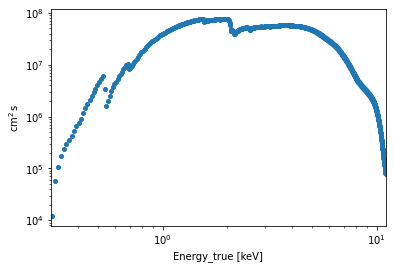

In [17]:
aeff=OGIPDatasetReader.read_arf(arffile,livetime=livetime)
aeff.plot()


In [18]:
map_geom = cube_data.geom.to_image().to_cube(axes=[aeff.geom.axes['energy_true']])
exposure = Map.from_geom(map_geom)
exposure.data += aeff.data.flatten()[:,None, None]
exposure.unit = u.cm**2 *u.s

exposure.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

Models

Component 0: SkyModel

  Name                      : shell
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : ShellSpatialModel
  Temporal model type       : 
  Parameters:
    NH           (frozen)   : 20000000000000000000000.000      1 / cm2     
    index                   :      2.500   +/-    0.00             
    amplitude               :   2.00e-03   +/- 0.0e+00 1 / (cm2 keV s)
    reference    (frozen)   :      1.000       keV         
    lon_0        (frozen)   :    210.189       deg         
    lat_0        (frozen)   :    -63.429       deg         
    radius       (frozen)   :     65.000       arcsec      
    width        (frozen)   :      5.000       arcsec      

Component 1: SkyModel

  Name                      : pwn
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : TemplateSpatialModel
  Temporal model type       : 
  Parameter

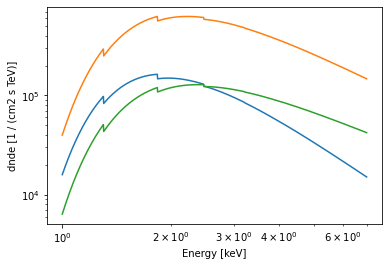

In [28]:
# Define sky model to simulate the data


wabs=WAbsSpectralModel(NH="2.e22 cm-2") #Value from Reynolds 2019


#PWN model
image=Map.read('data/Cube_IGRJ1400_46pix_XYrebin8_Erebin16_comp0.fits',map_type='wcs')
image.data[image.data<30] = 0

spatial_model = TemplateSpatialModel(image)
spectral_model = wabs*PowerLawSpectralModel(index=1.8, amplitude="5e-3 cm-2 s-1 keV-1", reference="1 keV")
pwn = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model,name='pwn')

pwn.parameters["index"].min = 1
pwn.parameters["index"].max = 5
pwn.parameters["NH"].frozen = True


# Shell model
spatial_model = ShellSpatialModel(lon_0=210.1891*u.deg,lat_0= -63.4287*u.deg,radius=65*u.arcsec,width=5*u.arcsec,frame='icrs')
spectral_model = wabs*PowerLawSpectralModel(index=2.5, amplitude="2.e-3 cm-2 s-1 keV-1", reference="1 keV")
shell = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model,name='shell')

#shell.spectral_model.NH = pwn.spectral_model.NH

shell.parameters['lon_0'].frozen = True
shell.parameters['lat_0'].frozen = True
shell.parameters['radius'].frozen = True
shell.parameters['width'].frozen = True
shell.parameters["NH"].frozen = True

#shell.spectral_model.NH =  pwn.spectral_model.NH
#shell.spectral_model.parameters['NH']=pwn.spectral_model.parameters['NH']

# PSR model
spatial_model = GaussianSpatialModel(lon_0=210.1905*u.deg, lat_0=-63.4283*u.deg,sigma=0.5*u.arcsec,frame='icrs')
spectral_model = wabs*PowerLawSpectralModel(index=1.5, amplitude="8.e-4 cm-2 s-1 keV-1", reference="1 keV")
psr = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model,name='psr')

psr.parameters['lon_0'].frozen = True
psr.parameters['lat_0'].frozen = True
psr.parameters["NH"].frozen = True

sky_model =  (shell + pwn + psr)
print(sky_model)


for n in sky_model.names:
    sky_model[n].spectral_model.plot(energy_bounds=[1, 7] * u.keV, n_points=1000)

In [29]:
shell.spectral_model.parameters['NH']

Parameter(name='NH', value=2e+22, factor=2e+22, scale=1.0, unit=Unit("1 / cm2"), min=0.0, max=nan, frozen=True, id=0x15de96910)

In [30]:
mask = Map.from_geom(cube_data.geom)
mask.data = False 
E1, E2 = 1*u.keV, 7*u.keV
i1,i2 =cube_data.geom.axes[0].coord_to_idx([E1,E2])
mask.data[i1:i2,:,:] = True

mask.plot_interactive(add_cbar=True)


interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [31]:
dataset = MapDataset(
    models=sky_model,
    counts=cube_data,
    exposure=exposure,
    edisp=edisp,
    psf=None,
    mask_fit=mask
)

In [32]:
npred=dataset.npred()
npred.plot_interactive(add_cbar=True)
#plt.plot(npred.data.sum(axis=(1,2)))

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [33]:
cube_data.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

/var/folders/tb/znw8973934s4jdxn0tf51ml19gyqj1/T/ipykernel_74041/1197305143.py:10: RuntimeWarning: divide by zero encountered in true_divide
  spec_resid=(spec_obs-spec_npred)/np.sqrt(spec_npred)
/var/folders/tb/znw8973934s4jdxn0tf51ml19gyqj1/T/ipykernel_74041/1197305143.py:10: RuntimeWarning: invalid value encountered in true_divide
  spec_resid=(spec_obs-spec_npred)/np.sqrt(spec_npred)


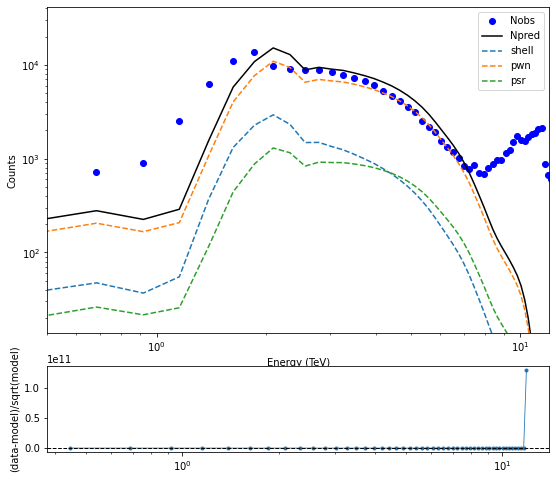

In [136]:
#%%time 
# Plot 1st guess
def plot_data_model(dataset,comp=True):
    npred=dataset.npred()
    e=npred.geom.axes[0].center
    spec_npred=npred.data.sum(axis=(1,2))
    spec_obs=dataset.counts.data.sum(axis=(1,2))

    
    spec_resid=(spec_obs-spec_npred)/np.sqrt(spec_npred)


    fig, ax1 = plt.subplots(1, 1, figsize=(9,6))   

    L=0.125
    #ax1=fig.add_axes((L,0.5,0.775,.4))
    ax1.loglog(e,spec_obs,color='blue',label='Nobs',marker='o',ls='None')
    ax1.loglog(e,spec_npred,color='black',label='Npred')
    if comp:
        for i,mod in enumerate(dataset.models):
            
            dataset_ = MapDataset(
                models=mod,
                counts=dataset.counts,
                exposure=dataset.exposure,
                edisp=dataset.edisp,
                mask_safe=mask)

            npred_comp = dataset_.npred()
            spec_npred_comp = npred_comp.data.sum(axis=(1,2))
            ax1.loglog(e,spec_npred_comp,ls='--',label=mod.name)        
    ax1.set_xlabel('Energy (TeV)')
    ax1.set_ylabel('Counts')
    ax1.set_ylim(spec_obs.max()*1e-3, spec_obs.max()*3)
    ax1.set_xlim(0.5,12)
    plt.legend()


    ax2=fig.add_axes((L,-.15,0.775,.2))


    ax2.plot(e,spec_resid,
                 marker='.',lw=0.8,label='residuals')

    ax2.set_xscale('log')    
    ax2.axhline(0, color='k', lw=1, ls='--')
    ax2.set_ylabel('(data-model)/sqrt(model)')
        
plot_data_model(dataset, comp=True)    

In [137]:
%%time
fit = Fit(optimize_opts={"print_level": 2})
result = fit.run(datasets=[dataset])

I MnSeedGenerator Initial state: FCN =       479419.9625 Edm =       8399.522873 NCalls =     35
I VariableMetricBuilder Start iterating until Edm is < 0.0002 with call limit = 1145
I VariableMetricBuilder    0 - FCN =       479419.9625 Edm =       8399.522873 NCalls =     35
I VariableMetricBuilder    1 - FCN =       475241.5833 Edm =       317.3938291 NCalls =     55
I VariableMetricBuilder    2 - FCN =       472885.2493 Edm =       1161.039291 NCalls =     72
I VariableMetricBuilder    3 - FCN =       471806.8332 Edm =       198.6486375 NCalls =     87
I VariableMetricBuilder    4 - FCN =       471579.1051 Edm =       63.38063473 NCalls =    103
I VariableMetricBuilder    5 - FCN =       471479.7988 Edm =       3.957972682 NCalls =    119
I VariableMetricBuilder    6 - FCN =       471470.2843 Edm =       2.969397706 NCalls =    135
I VariableMetricBuilder    7 - FCN =       471447.9178 Edm =       3.374894105 NCalls =    152
I VariableMetricBuilder    8 - FCN =       471444.2808 Edm

ValueError: Invalid covariance shape: (19, 19), expected (21, 21)